# Import Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#import sidetable as stb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

# Initialized Data

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Project

Airline Customer Clustering

Description:
Segmenting airline customers

# Load and Describe Data

## Load Data

In [ ]:
# load dataset
df = pd.read_csv('/kaggle/input/airline-customer/flight.csv')

# show five random data
df.sample(5)

##  Data Definition

Feature name  | Description
-------------------|-------------
MEMBER_NO-b | Member ID
FFP_DATE | Frequent Flyer Program Join Date
FIRST_FLIGHT_DATE | First Flight Date
GENDER | Gender
FFP_TIER | Frequent Flyer Program Tier
WORK_CITY | Work City
WORK_PROVINCE | Work Proviince
WORK_COUNTRY | Work Country
AGE | Customer Age
LOAD_TIME | Date data was taken
FLIGHT_COUNT | Number of customer flights
BP_SUM | Rencana Perjalanan
SUM_YR_1 | Fare Revenue
SUM_YR_2 | Votes Prices
SEG_KM_SUM | Total distance (km) flights that have been done
LAST_FLIGHT_DATE | Last Flight Date
LAST_TO_END | last flight time to last flight order interval
AVG_INTERVAL | Average time distance
MAX_INTERVAL | Maximum time distance
EXCHANGE_COUNT | Number of redemptions
avg_discount | The average discount that customers get
Points_Sum | The number of points earned by the customer
Point_NotFlight | Points not used by members
 

## Checking Columns and Missing Values With df.info()

In [ ]:
df.info()

From the data type information:

* For `FFP_DATE`, `FIRST_FLIGHT_DATE`, `LOAD_TIME`, `LAST_FLIGHT_DATE` columns should be of type datetime because they are date data
* For the `AGE` column it seems more ideal to use the *int64* data type
* For data type adjustments, it will be done in the Adjust Data Type stage


Then we can see that:

* The dataframe has a total of 62,988 rows and 23 columns.
* Missing values are visible in the columns `GENDER`, `WORK_CITY`, `WORK_PROVINCE`, `WORK_COUNTRY`, `AGE`, `SUM_YR_1`,`SUM_YR_2`

From the information above, we can separate the categorical and numeric columns as follows:

In [ ]:
#Numeric
numeric = df.loc[:, (df.dtypes == int) | (df.dtypes == float)].columns.tolist()
numeric

In [ ]:
#Categorical
categorical = df.loc[:, (df.dtypes != int) & (df.dtypes != float)].columns.tolist()
categorical

## Sampling to Understand Data With df.sample()

In [ ]:
df.sample(5)

It can be seen from the sample above, between the columns and their values there is nothing strange and in accordance with the data definition

## Statistical summary dengan df.describe()

In [ ]:
df[numeric].describe().apply(lambda x: x.apply('{0:.5f}'.format))

Some observations from the statistical summary of the numeric column above:

* A total of 15 numeric columns
* For columns `MEMBER_NO`, `FFP_TIER` and `avg_discount` appear to have a normal distribution with mean values equal to/close to the median
* In addition, the majority of columns appear to have a positively skewed distribution (Mean > Median). There may be outliers
* It can be seen that there is a fare price with a value of 0. It can be seen in the `SUM_YR_1` and `SUM_YR_2` columns. Needs to be analyzed further
* It can be seen that there is an average discount of 0. It can be seen in the `avg_discount` column. Needs to be analyzed further
* Seen there is a customer who is 110 years old. It can be seen in the `AGE` column. Looks like it can be deleted because it's abnormal

In [ ]:
df[categorical].describe()

Some observations from the statistical summary of the categorical column above:

* A total of 8 categorical columns
* The majority of customers are Male with a frequency of 48,134
* The majority of columns have a large number of uniques, except for the `GENDER` column
* Seen from the `LOAD_TIME` column, this dataset was taken on 31-3-2014, it can be used as a cut off date

# Data Pre-Processing

## Initialize df_clean

In [ ]:
df_clean = df.copy()

## Check Null and Missing Values

In [ ]:
data_missing_value = df_clean.isnull().sum().reset_index()
data_missing_value.columns = ['feature','missing_value']
data_missing_value['percentage'] = round((data_missing_value['missing_value']/len(df_clean))*100,3)
data_missing_value = data_missing_value.sort_values('percentage', ascending=False).reset_index(drop=True)
data_missing_value = data_missing_value[data_missing_value['percentage']>0]
data_missing_value

In [ ]:
col_missing_value = data_missing_value['feature'].tolist() 
df_clean[col_missing_value].info()

According to the previous analysis, the missing value is found in 7 columns, with the highest percentage in the `WORK_PROVINCE` column of 5.16%

## Handle Missing Value

For columns `SUM_YR_1`, `AGE`, `SUM_YR_2`, `WORK_COUNTRY`, `GENDER` because the missing value is below 1%, we will drop these rows

In [ ]:
missing_col = ['SUM_YR_1', 'AGE', 'SUM_YR_2', 'WORK_COUNTRY', 'GENDER']
for col in missing_col:
  df_clean.dropna(subset=[col], inplace=True)

For the `WORK_CITY` and `WORK_PROVINCE` columns, we will enter the mode value of each column in the missing row.

In [ ]:
df_clean['WORK_CITY'].fillna(df_clean['WORK_CITY'].mode()[0], inplace=True)
df_clean['WORK_PROVINCE'].fillna(df_clean['WORK_PROVINCE'].mode()[0], inplace=True)

In [ ]:
data_missing_value = df_clean.isnull().sum().reset_index()
data_missing_value.columns = ['feature','missing_value']
data_missing_value

## Incorrect Value

It can be seen in the `LAST_FLIGHT_DATE` column that there is an incorrect value, 2014/2/29, where there should be no such date.

In [ ]:
df_clean[df_clean.LAST_FLIGHT_DATE.str.contains('2014/2/29')]

In [ ]:
print('Incorrect `LAST_FLIGHT_DATE` data percentage: ', end='\n\n')
print(str(round(df_clean[df_clean.LAST_FLIGHT_DATE.str.contains('2014/2/29')]['LAST_FLIGHT_DATE'].count()/len(df_clean), 3)), '%')

Because the incorrect data in the `LAST_FLIGHT_DATE` column is only 0.007%, we can drop these rows

In [ ]:
df_clean.drop(df_clean[df_clean.LAST_FLIGHT_DATE.str.contains('2014/2/29')].index, inplace = True)

In [ ]:
df_clean[df_clean.LAST_FLIGHT_DATE.str.contains('2014/2/29')]['LAST_FLIGHT_DATE'].count()

## Adjust Data Type

Change the data type in the `AGE` column from *float64* to *int64*

In [ ]:
df_clean['AGE'] = df_clean['AGE'].astype(int) 

Change the data type in the `FFP_DATE`, `FIRST_FLIGHT_DATE`, `LOAD_TIME`, `LAST_FLIGHT_DATE` columns from object to datetime

In [ ]:
date_col = ['FFP_DATE', 'FIRST_FLIGHT_DATE', 'LOAD_TIME','LAST_FLIGHT_DATE']
for col in date_col:
  df_clean[col] = pd.to_datetime(df_clean[col])

In [ ]:
df_clean.info()

## Feature Engineering

### Membership Duration (In Months)

By subtracting the last time the dataset was retrieved by the time of joining the membership, we can obtain membership duration data, which reflects whether the member is an old customer.

In [ ]:
df_clean['MEMBER_DURATION'] = ((df_clean['LOAD_TIME'] - df_clean['FFP_DATE'])/np.timedelta64(1, 'M'))
df_clean['MEMBER_DURATION'] = df_clean['MEMBER_DURATION'].astype(int)

In [ ]:
df_clean.sample(2)

## Duplicate Values

In [ ]:
df_clean.duplicated().sum()

There are no duplicate rows in this dataset

In [ ]:
print('Total Row', df_clean.shape[0], ', Total Feature', df_clean.shape[1],'\n')

## Redefine Numeric and Categorical

In [ ]:
#Numeric
numeric = df_clean.loc[:, (df_clean.dtypes == int) | (df_clean.dtypes == float)].columns.tolist()
numeric

In [ ]:
#Categorical
categorical = df_clean.loc[:, (df_clean.dtypes != int) & (df_clean.dtypes != float) & (df_clean.columns != 'publish_daytype') & ((df_clean.columns != 'trending_daytype'))].columns.tolist()
categorical

# Exploratory Data Analysis

## Univariate Analysis

### Box Plot

In [ ]:
# boxplot visualization for numerical data

plt.figure(figsize=(15, 25))
for i in range(0, len(numeric)):
    plt.subplot(8, 2, i+1)
    sns.boxplot(x=df_clean[numeric[i]], color='orange')
    plt.tight_layout()

plt.show()

From the box plot observations:

* The majority of the columns have outliers, except for the `MEMBER_NO`, `FFP_TIER` and `MEMBER_DURATION` columns

### Dist Plot

In [ ]:
# distribution plot for numerical data

plt.figure(figsize=(10, 30))
for i in range(0, len(numeric)):
    plt.subplot(8, 2,i+1)
    sns.distplot(df_clean[numeric[i]], color='orange')
    plt.tight_layout()

From the observations of the Dist Plot:

* he majority of columns appear to have a positive skewed distribution, except for the `MEMBER_NO`, `FFP_TIER` and `avg_discount` columns

### Count Plot

In [ ]:
plt.figure(figsize=(10, 30))
for i in range(0, len(categorical)):
    plt.subplot(8, 1, i+1)
    sns.countplot(df_clean[categorical[i]])
    plt.tight_layout()

From Count Plot's observations:

* Most members are Male
* Majority of the columns have a large number of unique values
* For column `LOAD_TIME` has 1 value, that is 2014-03-31

## Multivariate Analysis

### Correlaction/Associations Heat Map

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_clean.corr(), cmap='Blues', annot=True, fmt='.2f')
plt.show()

It can be seen that there is a correlation between several attributes, assuming > 0.5 has a fairly strong positive correlation:

* `FIRST_FLIGHT_DATE` correlation with `FFP_DATE` = 0.86
* Correlation of `WORK_PROVINCE` with `WORK_CITY` = 0.81
* Correlation of `WORK_PROVINCE` with `WORK_COUNTRY` = 0.70
* Correlation of `WORK_PROVINCE` with WORK_CITY` = 0.85
* `BP_SUM` correlation with `FLIGHT_COUNT` = 0.79
* `BP_SUM` correlation with `FFP_TIER` = 0.58
* `BP_SUM` correlation with `EXCHANGE_COUNT` = 0.53
* Correlation of `FLIGHT_COUNT` with `FFP_TIER` = 0.58
* Correlation `SUM_YR_1` with `FLIGHT_COUNT` = 0.75
* Correlation `SUM_YR_1` with `BP_SUM` = 0.85
* Correlation `SUM_YR_1` with `SUM_YR_2` = 0.66
* Correlation of `SUM_YR_1` with `SEG_KM_SUM` = 0.80
* Correlation `SUM_YR_1` with `Points_Sum` = 0.79
* Correlation `SUM_YR_2` with `FFP_TIER` = 0.61
* Correlation of `SUM_YR_2` with `FLIGHT_COUNT` = 0.80
* Correlation of `SUM_YR_2` with `BP_SUM` = 0.88
* Correlation of `SUM_YR_2` with `SEG_KM_SUM` = 0.85
* Correlation `SUM_YR_2` with `Points_Sum` = 0.83
* `SEG_KM_SUM` correlation with `FFP_TIER` = 0.52
* `SEG_KM_SUM` correlation with `FLIGHT_COUNT` = 0.85
* `SEG_KM_SUM` correlation with `BP_SUM` = 0.92
* Correlation of `SEG_KM_SUM` with `EXCHANGE_COUNT` = 0.51
* Points_Sum correlation with `FFP_TIER` = 0.56
* Points_Sum correlation with `FLIGHT_COUNT` = 0.75
* Points_Sum correlation with `BP_SUM` = 0.92
* Points_Sum correlation with `SEG_KM_SUM` = 0.85
* Points_Sum correlation with `EXCHANGE_COUNT` = 0.58
* Correlation `MAX_INTERVAL` with `AVG_INTERVAL` = 0.72

### Pair Plot

In [ ]:
plt.figure(figsize=(15, 15))
sns.pairplot(df_clean, diag_kind='kde')
plt.show()

In pairplot, it can be seen that there is a linear correlation between several columns

## EDA Conclusion

Some of the things we found from this EDA dataset are:

* The data looks valid and there are no defects.
* The majority of numeric columns have a positive skewed distribution, this must be remembered if we want to do something or use a model that requires the assumption of a normal distribution.
* The majority of numeric columns also have outliers, except for the FFP_TIER and MEMBER_DURATION . columns
* The majority of categorical columns have a large number of uniques except for the GENDER and LOAD_TIME . columns
* Many columns have a strong positive correlation with each other

# Data Pre-Processing Part 2

## Outliers

From the EDA process, it can be seen that there are customers who are 110 years old. Can be considered as an anomaly, therefore the data is deleted

In [ ]:
df_clean[df_clean.AGE > 100]

In [ ]:
df_clean.drop(df_clean[df_clean.AGE > 100].index, inplace = True)

From the results of previous observations, it appears that there is a ticket price column with a value of 0. Then checks are also made on the total distance of flights that have been carried out and the average discount obtained.

Here we can see that there are flight data with ticket prices 0, the average discount is 0, but the total flight distance is more than 0. It can be considered as an anomaly, and because the number is small (7 rows), we can drop these rows.

In [ ]:
df_clean[(df_clean.SUM_YR_1 == 0) & (df_clean.SUM_YR_2 == 0) & (df_clean.avg_discount == 0) & (df_clean.SEG_KM_SUM > 0)]

In [ ]:
df_clean.drop(df_clean[(df_clean.SUM_YR_1 == 0) & (df_clean.SUM_YR_2 == 0) & (df_clean.avg_discount == 0) & (df_clean.SEG_KM_SUM > 0)].index, inplace = True)

In [ ]:
print('Total Row', df_clean.shape[0], ', Total Feature', df_clean.shape[1],'\n')

## Feature Selection

### RFM

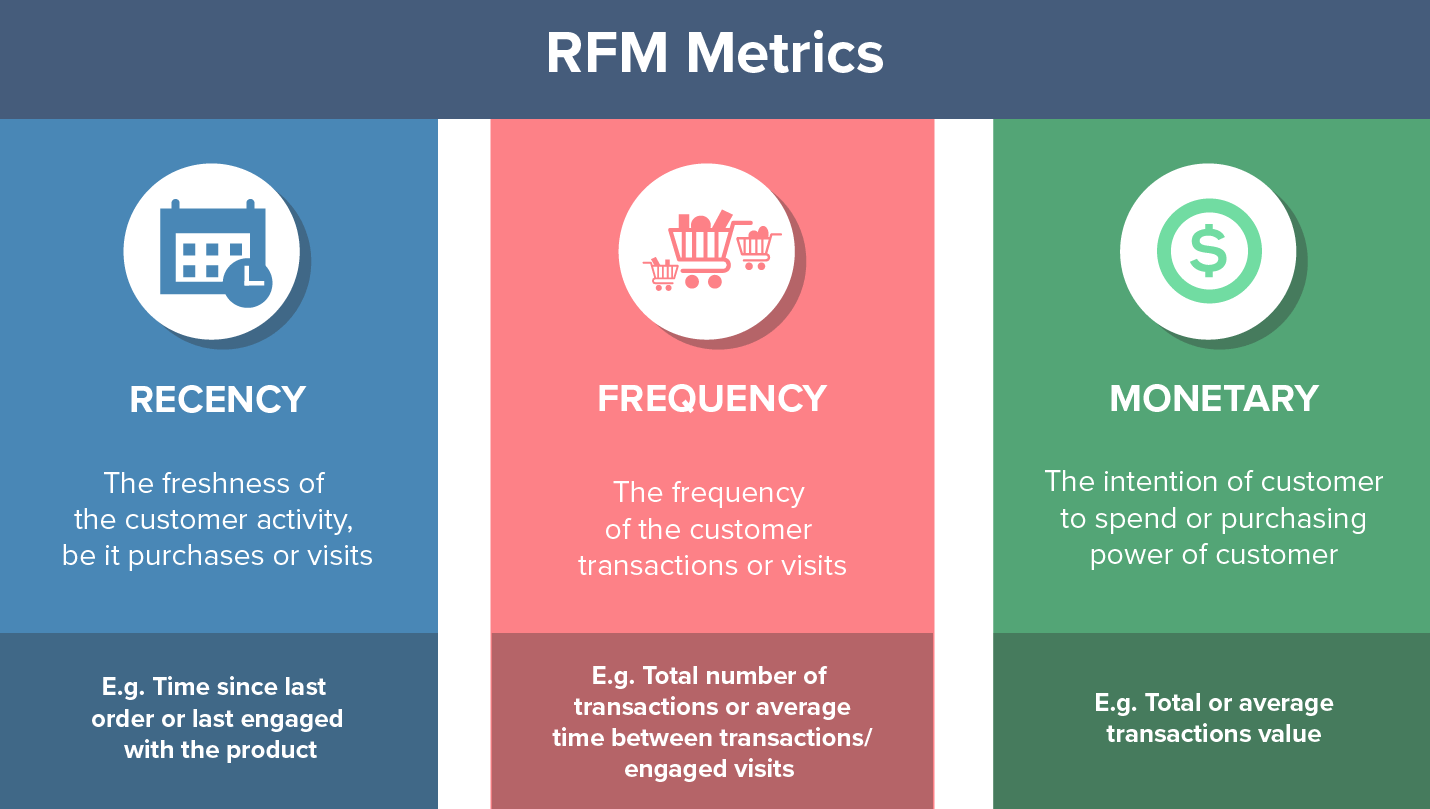

Using the RFM concept as shown above in performing feature selection:

* Recency -> column `LAST_TO_END`
    - Distance from last flight time to last flight order
* Frequency -> column `FLIGHT_COUNT`
    - Number of customer flights
* Monetary -> column `SEG_KM_SUM`
    - For the monetary column, as an adjustment in the airline business, this feature is replaced by accumulated flight hours within a certain period of time


Then there are also columns that are considered important in assessing customer value in the aviation business, namely:

* Loyalty -> column `MEMBER_DURATION`
    - Membership length, which reflects whether the member is an existing customer
* Cabin -> column `avg_discount`
    - Discount factor related to cabin class, reflecting high and low customer value


These columns will be used in the clustering process



In [ ]:
df_select = df_clean.copy()

In [ ]:
df_select = df_select[['MEMBER_DURATION','LAST_TO_END','FLIGHT_COUNT','SEG_KM_SUM','avg_discount']]
df_select.sample(5)

## Normalization/Standardization

Prior to clustering, the data needs to be standardized/normalized so that each feature has the same scale. 
In this case normalization is used, because the data has a positive skewed distribution.

For `AGE` column, we use standardization, because the distribution looks normal

In [ ]:
# Before scaling
df_select.describe().apply(lambda x: x.apply('{0:.5f}'.format))

In [ ]:
# Normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

norm_col = ['MEMBER_DURATION', 'LAST_TO_END', 'FLIGHT_COUNT', 'SEG_KM_SUM']

for col in norm_col:
  df_select[col + '_NORM'] = MinMaxScaler().fit_transform(df_select[col].values.reshape(len(df_select), 1))

# Standardization
df_select['avg_discount_STD'] = StandardScaler().fit_transform(df_select['avg_discount'].values.reshape(len(df_select), 1))

In [ ]:
# After scaling
df_select.describe().apply(lambda x: x.apply('{0:.5f}'.format))

### Initialize df_select_std

In [ ]:
df_select_std = df_select.copy()
df_select_std = df_select_std[['MEMBER_DURATION_NORM', 'LAST_TO_END_NORM', 'FLIGHT_COUNT_NORM', 'SEG_KM_SUM_NORM', 'avg_discount_STD']]

In [ ]:
df_select_std.sample(5)

# Clustering (K-Means)

Finding the ideal number of clusters using the Inertia and Silhouette Score methods

## Inertia

In [ ]:
from sklearn.cluster import KMeans
inertia = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_select_std)
    inertia.append(kmeans.inertia_)



plt.figure(figsize=(20, 10))

sns.lineplot(x=range(2, 11), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2, 11), y=inertia, s=300, color='#800000',  linestyle='--')
plt.show()

## Silhouette Score

In [ ]:
from sklearn.metrics import silhouette_score

range_n_clusters = list(range(2,11))
arr_silhouette_score_euclidean = []
for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i).fit(df_select_std)
    preds = kmeans.predict(df_select_std)
     
    score_euclidean = silhouette_score(df_select_std, preds, metric='euclidean')
    arr_silhouette_score_euclidean.append(score_euclidean)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(x=range(2,11), y=arr_silhouette_score_euclidean, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2,11), y=arr_silhouette_score_euclidean, s=300, color='#800000',  linestyle='--')
plt.show()

Seen from the evaluation using Inertia or Silhouette Score, information obtained the ideal number of clusters is 3 clusters.

## Create Clusters

Create clusters using K-Means method

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_select_std)

## Assign Cluster to Dataset

In [ ]:
clusters = kmeans.labels_

In [ ]:
df_clean['clusters'] = clusters

In [ ]:
df_clean.sample(5)

# Clusters Analysis

## Dimensionality Reduction for Visualization

In [ ]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=2)

pca.fit(df_select_std)
pcs = pca.transform(df_select_std)

df_pca = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2'])
df_pca.head()

In [ ]:
df_pca['clusters'] = clusters
df_pca.head(2)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

sns.scatterplot(
    x='PC 1', y='PC 2',
    hue='clusters',
    linestyle='--',
    data=df_pca,
    s=160,
    ax=ax
)

plt.show()

## Analysis

In [ ]:
df_clean[['MEMBER_DURATION', 'LAST_TO_END', 'FLIGHT_COUNT', 'SEG_KM_SUM', 'avg_discount', 'clusters']].groupby('clusters').median()

In [ ]:
df_clean['clusters'].value_counts().to_frame().reset_index().rename(columns={"index": "clusters", "clusters": "total_members"})


* Cluster 0 (middle value customer):
    - Mid-level flight recency
    - Mid-level flight frequency
    - Mid-level airline mileage
    - The middle level of average discount, shows the middle level of flight class
    - Membership duration between cluster 1 and cluster 2
    - Highest number of cluster members
    - As a potential customer, airline can encourage these customers to increase transactions
* Cluster 1 (low value customer):
    - Highest level flight recency (longest)
    - Lowest rate flight frequency
    - Lowest level of airline mileage
    - In the average discount level, it shows the lower level flight class
    - Most recent membership duration
    - Middle number of cluster members
    - Airline needs to increase interaction with these customers and needs to take certain marketing strategies to extend this customer cycle
* Cluster 2 (high value customers):
    - Lowest level flight recency (most recent)
    - Highest level of flight frequency
    - Highest level of airline mileage
    - The highest level of average discount, shows the highest level of flight class
    - Longest membership duration
    - Lowest number of cluster members
    - They are the most ideal type of customer, they contribute the most to the airline. They are also loyal. Airline needs to provide special management for these customers and improve their satisfaction

## Compare New Cluster With Existing Cluster Based on FFP Tier

In [ ]:
df_tier = df_pca.copy()
df_tier['clusters'] = df_clean['FFP_TIER']
df_tier.head(2)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

sns.scatterplot(
    x='PC 1', y='PC 2',
    hue='clusters',
    linestyle='--',
    data=df_tier,
    s=160,
    ax=ax
)

plt.show()

In [ ]:
df_clean[['MEMBER_DURATION', 'LAST_TO_END', 'FLIGHT_COUNT', 'SEG_KM_SUM', 'avg_discount', 'FFP_TIER']].groupby('FFP_TIER').median()

With the same features, it appears that the FFP TIER-based cluster is still not ideal in separating cluster members